<a href="https://colab.research.google.com/github/mascDriver/data-science/blob/main/GEX637_Trabalho_4(refatorando)_%E2%80%93_Busca_Gulosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

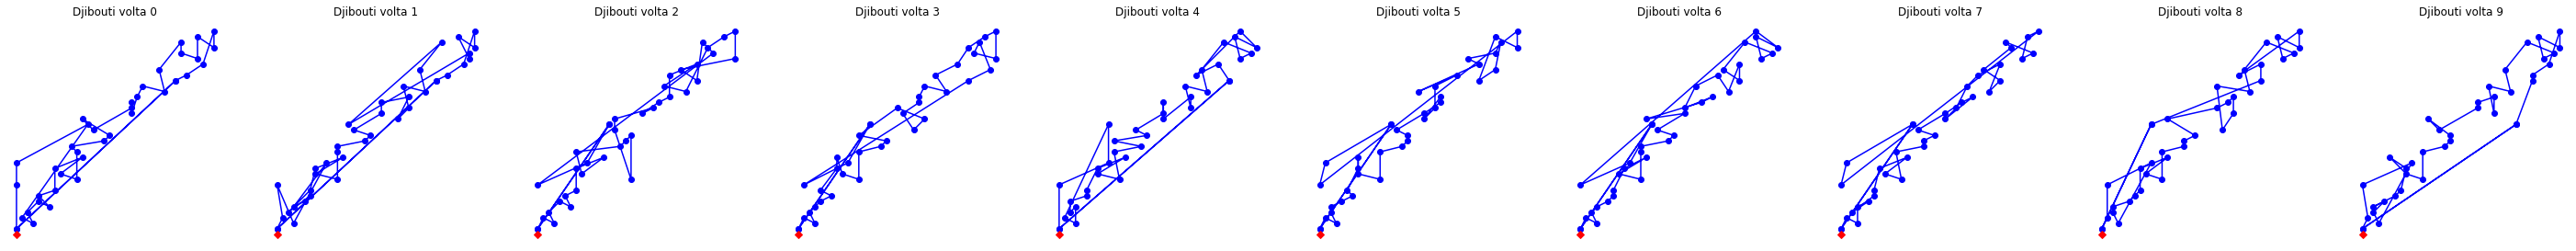

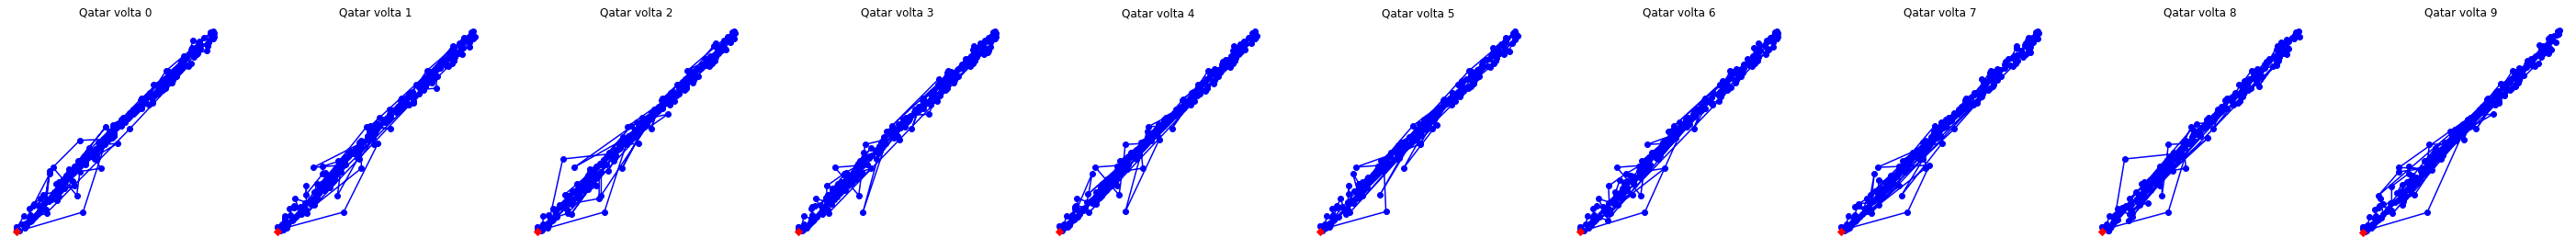

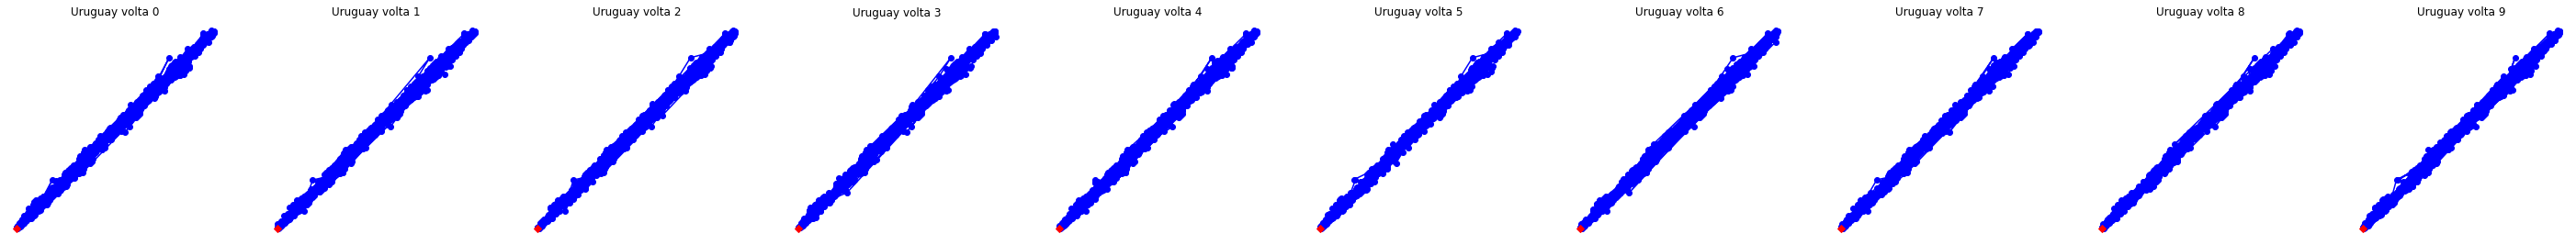

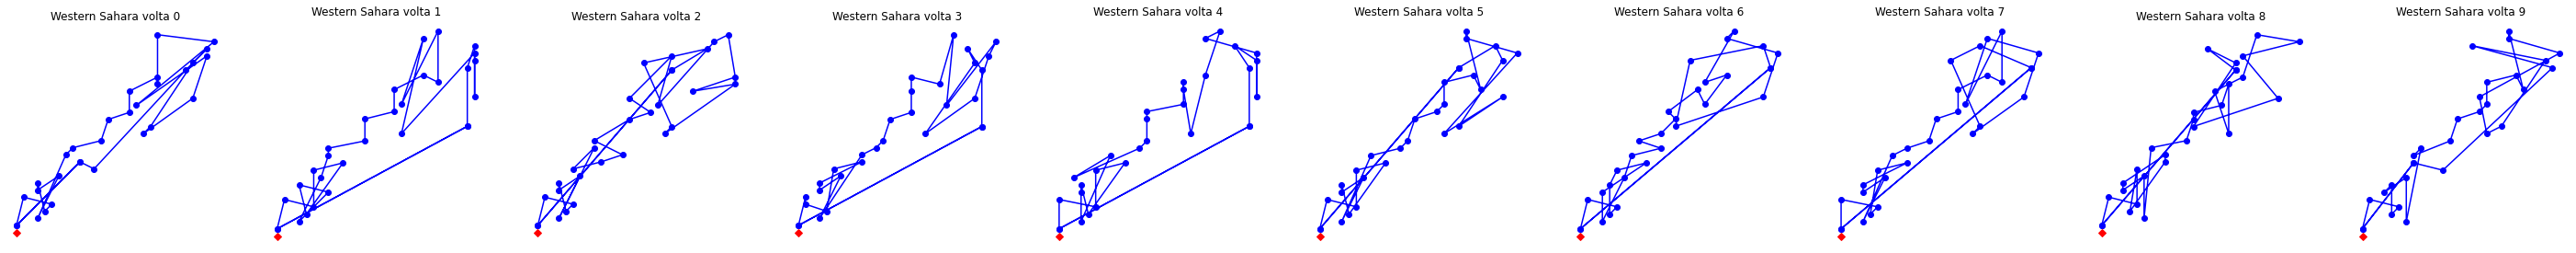

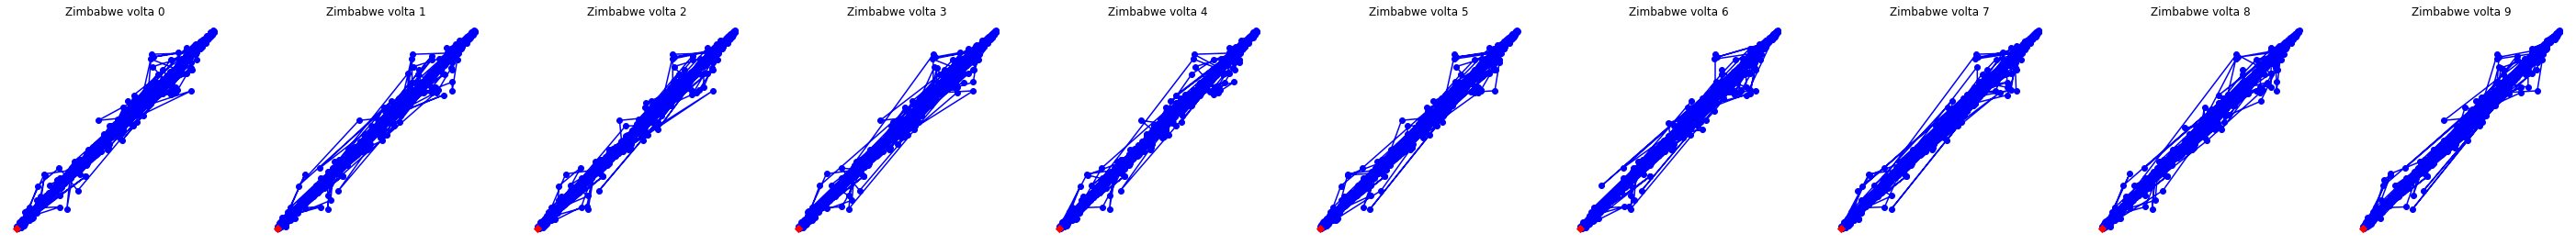

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from scipy.spatial import distance_matrix

instances = {
    "dj38.tsp": "Djibouti",
    "qa194.tsp": "Qatar",
    "uy734.tsp": "Uruguay",
    "wi29.tsp": "Western Sahara",
    "zi929.tsp": "Zimbabwe",
}

path = '/content/drive/MyDrive/GEX637/'

class Tsp():
  def read_tsp(self, filename):
    with open(filename) as f:
        node_coord_start = None
        dimension = None
        lines = f.readlines()
        i = 0
        while not dimension or not node_coord_start:
            line = lines[i]
            if line.startswith('DIMENSION :') or line.startswith('DIMENSION:'):
                dimension = int(line.split()[-1])
                self.dimension = dimension
            if line.startswith('NODE_COORD_SECTION'):
                node_coord_start = i
            i = i+1
        f.seek(0)
        cities = pd.read_csv(
            f,
            skiprows=node_coord_start + 1,
            sep=' ',
            names=['city', 'x', 'y'],
            dtype={'city': str, 'x': np.float64, 'y': np.float64},
            header=None,
            nrows=dimension
        )
        self.cities = cities

  def matrix(self):
    self.matrix_distance = distance_matrix(self.cities[['x', 'y']].values, self.cities[['x', 'y']].values)

class GreedySearch():
  def __init__(self, matrix_distance, dimension) -> None:
      self.matrix_distance = matrix_distance
      self.dimension = dimension
      self.positive_inf = float('inf')
      self.selected_nodes = np.full(self.dimension, False)
      self.result = np.zeros((self.dimension, self.dimension), dtype=int)
      self.quality = 0

  def mst(self):
    # used here Prim's algorithm - minimum spanning tree

    elapsed_time_instance =  self.dimension * 0.06
    elapsed_time = 0
    t = time.perf_counter()

    while(elapsed_time < elapsed_time_instance):
      citys = np.arange(self.dimension)
      city_random = np.random.randint(self.dimension)
      citys = np.delete(citys, city_random)
      citys = np.append(city_random, citys)
      # citys = np.append(citys, city_random)
      while(False in self.selected_nodes):
        minimum = self.positive_inf
        start = city_random
        end = 0
        for i in citys:
          if self.selected_nodes[i]:
            np.random.shuffle(citys)
            for j in citys:
              if not self.selected_nodes[j] and self.matrix_distance[i][j]>0:
                if self.matrix_distance[i][j] < minimum:
                  minimum = self.matrix_distance[i][j]
                  start, end = i, j
        self.selected_nodes[end] = True

        if minimum == self.positive_inf:
          self.result[start][end] = 0
        else:
          self.result[start][end] = round(minimum)
          try:
            self.result_route = np.append([[start, end]], self.result_route, axis=0)
          except:
            self.result_route = np.array([[start, end]])
      
      elapsed_time = time.perf_counter() - t
    self.result_route = np.append(self.result_route, [self.result_route[0], self.result_route[-1]], axis=0)

  def calculate_quality(self):
    temp_route = np.append(self.result_route, [self.result_route[0]], axis=0)
    for x, y in temp_route:
      self.quality += self.matrix_distance[x][y]
    
def plot_tour(tour, axes, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    start = tour[0:1]
    plot_segment(tour + start, axes, style)
    plot_segment(start, axes, 'rD-') # start city is red Diamond.
    
def plot_segment(segment, axes, style='bo-'):
    "Plot every city and link in the segment."
    axes.plot([c[0] for c in segment], [c[1] for c in segment], style, clip_on=False)
    axes.axis('scaled')
    axes.axis('off')


def main():
  resultados = []
  for filename in os.scandir(path):
    # if filename.name != 'wi29.tsp': continue
    tsp = Tsp() # instancia a class responsavel por arquivos tsp
    tsp.read_tsp(filename) # extrai os dados necessarios para utilizar no cod
    tsp.matrix() # cria matriz de distancias euclidianas

    quality = []
    time_execution = []
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(50, 25))
    for _ in range(10):
      graph = GreedySearch(tsp.matrix_distance, tsp.dimension) # instancia busca gulosa
      t = time.perf_counter()
      graph.mst() # utiliza algoritmo arvore geradora minima para resolver problema
      graph.calculate_quality() # calcula qualidade encontrada no algoritmo anterior
      quality.append(graph.quality)
      time_execution.append(time.perf_counter() - t)
      axes[_].set_title(f'{instances[filename.name]} volta {_}')
      plot_tour(graph.result_route, axes[_])
      # print(list(graph.result_route), '\n')

    resultados.append({
        'instancia': instances[filename.name],
        'autoria': 'Diogo.Baltazar',
        'algoritmo': 'BCGα',
        'q-medio': round(np.mean(quality)),
        'q-desvio': round(np.std(quality), 2),
        't-medio': round(np.mean(time_execution))
    })
  pd.DataFrame(resultados).to_csv('resultados.csv', index=False)
main()

In [17]:
pd.read_csv('resultados.csv')

,instancia,autoria,algoritmo,q-medio,q-desvio,t-medio
0,Djibouti,Diogo.Baltazar,BCGα,7643,270.07,2
1,Qatar,Diogo.Baltazar,BCGα,9557,252.31,12
2,Uruguay,Diogo.Baltazar,BCGα,75450,467.04,110
3,Western Sahara,Diogo.Baltazar,BCGα,29489,2213.97,2
4,Zimbabwe,Diogo.Baltazar,BCGα,92083,1248.60,211


In [7]:
pd.DataFrame([{'instancia': 'dj38', 'q-medio': 6656}, {'instancia': 'qa194', 'q-medio': 9352}, {'instancia': 'uy734', 'q-medio': 79114}, {'instancia': 'wi29', 'q-medio': 27603}, {'instancia': 'zi929', 'q-medio': 95345}])

,instancia,q-medio
0,dj38,6656
1,qa194,9352
2,uy734,79114
3,wi29,27603
4,zi929,95345
